tb - 7/18/2022 - Adapting equation learning from data to Earth-like situations

# Imports and Initialization

## Libraries

In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import PolynomialFeatures

from cbrain.cam_constants import *
from cbrain.climate_invariant import *
from cbrain.equation_discovery import *
from cbrain.preprocessing.convert_dataset_20191113 import compute_LHF_nsDELQ
from cbrain.climate_invariant_utils import *
from scipy.integrate import cumtrapz,trapz
from scipy import interpolate,misc

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pickle
import xarray as xr

/nfspool-0/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog


## Figure parameters

In [2]:
fz = 12
lw = 2
siz = 100

plt.rc('text', usetex=False)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw

## Paths to data

In [3]:
path_data = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/SPCAM_PHYS/'
path_array = {}
climate_str = ['cold','hot','both']
set_str = ['train','valid','test']
test_clim_str = ['cold','hot','both','medium']
climates = ['cold','medium','hot']
path_array['cold'] = [path_data+'2021_04_18_RG_TRAIN_M4K_shuffle.nc',
                      path_data+'2021_04_18_RG_VALID_M4K.nc',
                      path_data+'2021_04_18_RG_TEST_M4K.nc']
path_array['hot'] = [path_data+'2021_04_18_RG_TRAIN_P4K_shuffle.nc',
                     path_data+'2021_04_18_RG_VALID_P4K.nc',
                     path_data+'2021_04_18_RG_TEST_P4K.nc']
path_array['both'] = ['','','']
path_array['medium'] = [path_data+'2021_06_03_RG_TRAIN_shuffle.nc',
                        path_data+'2021_06_03_RG_VALID.nc',
                        path_data+'2021_06_06_RG_TEST.nc']
path_input_norm = path_data + '2021_04_18_NORM_RG_small.nc'
path_train_RH = path_data + '2021_01_24_O3_small_shuffle.nc'
path_norm_RH = path_data + '2021_02_01_NORM_O3_RH_small.nc'
path_train_BMSE = path_data + '2021_06_16_BMSE_small_shuffle.nc'
path_norm_BMSE = path_data + '2021_06_16_NORM_BMSE_small.nc'
path_train_LHF_nsDELQ = path_data + '2021_02_01_O3_LHF_nsQ_small_shuffle.nc'
path_norm_LHF_nsDELQ = path_data + '2021_02_01_NORM_O3_LHF_nsDELQ_small.nc'
in_vars = ['QBP','TBP','PS','SOLIN','SHFLX','LHFLX'] # We take the large-scale climate state as inputs
out_vars = ['PHQ','TPHYSTND','QRL','QRS'] # and we output the response of clouds/storms to these climate conditions
scale_dict = pickle.load(open(path_data+'009_Wm2_scaling.pkl','rb'))
path_CI = {}
path_CI['cold'] = [path_data+'2022_07_21_RG_B_RH_LHFns_TRAIN_m4K.nc','',path_data+'2022_07_21_RG_B_RH_LHFns_TEST_m4K.nc']
path_CI['hot'] = [path_data+'2022_07_21_RG_B_RH_LHFns_TRAIN_p4K.nc','',path_data+'2022_07_21_RG_B_RH_LHFns_TEST_p4K.nc']
scale_dict_RH = scale_dict.copy()
scale_dict_RH['RH'] = 0.01*L_S/G, # Arbitrary 0.1 factor as specific humidity is generally below 2%

## Load data

In [4]:
train = {}; test = {}; trainCI = {}; testCI = {};

In [5]:
for clim in climates:
    train[clim] = xr.open_dataset(path_array[clim][0])
    test[clim] = xr.open_dataset(path_array[clim][2])
for clim in ['cold','hot']:
    trainCI[clim] = xr.open_dataset(path_CI[clim][0])
#    testCI[clim] = xr.open_dataset(path_CI[clim][2])

In [6]:
ind_input = np.arange(0,64)
ind_output = np.arange(64,64+60)

In [7]:
xtrain = {}; ytrain = {}; xRHtrain = {}; xBtrain = {}; xLHFnstrain = {};

In [8]:
trainCI['cold']

<xarray.Dataset>
Dimensions:            (pressure: 30, pressure_interface: 31, samples_both: 143161344)
Coordinates:
    pressure_midlevel  (pressure) float64 ...
    pressure_interfac  (pressure_interface) float32 ...
    samples_mixed      (samples_both) int64 ...
Dimensions without coordinates: pressure, pressure_interface, samples_both
Data variables:
    RH_train           (samples_both, pressure) float32 ...
    B_train            (samples_both, pressure) float32 ...
    LHFnsDELQ_train    (samples_both) float32 ...
Attributes:
    description:  RH, B, and LHF_nsDELQ calculated using script [098]

In [9]:
for iclim,clim in enumerate(['cold','hot']):
    xtrain[clim] = train[clim]['vars'][:,ind_input]
    xRHtrain[clim] = trainCI[clim]['RH_train']
    xBtrain[clim] = trainCI[clim]['B_train']
    xLHFnstrain[clim] = trainCI[clim]['LHFnsDELQ_train']
    ytrain[clim] = train[clim]['vars'][:,ind_output]

In [10]:
KEYS = {}
KEYS['local'] = ['ps', 'S0', 'SHF', 'LHF','LHFns','p', 'q', 'dq_dp_FD',
              'd2q_dp2_FD','T', 'dT_dp_FD','d2T_dp2_FD','RH', 'dRH_dp_FD',
              'd2RH_dp2_FD','B', 'dB_dp_FD','d2B_dp2_FD']
KEYS['localCI'] = ['ps', 'S0', 'SHF','LHFns','p','RH', 'dRH_dp_FD',
              'd2RH_dp2_FD','B', 'dB_dp_FD','d2B_dp2_FD']
KEYS['localBF'] = ['ps', 'S0', 'SHF', 'LHF', 'p', 'q', 'dq_dp_FD',
              'd2q_dp2_FD','T', 'dT_dp_FD','d2T_dp2_FD']
KEYS['all'] = np.concatenate((KEYS['local'],['Q_above','Q_below','T_below','T_above',
                                             'RH_below','RH_above','B_below','B_above']))
KEYS['BF'] = np.concatenate((KEYS['localBF'],['Q_above','Q_below','T_below','T_above']))
KEYS['CI'] = np.concatenate((KEYS['localCI'],['RH_below','RH_above','B_below','B_above']))
scalar_keys = ['ps','S0','SHF','LHF','LHFns']
vector_keys = ['p', 'q', 'dq_dp_FD', 'd2q_dp2_FD', 'Q_above', 'Q_below',
               'T', 'dT_dp_FD', 'd2T_dp2_FD', 'T_above', 'T_below',
               'RH', 'dRH_dp_FD', 'd2RH_dp2_FD', 'RH_above', 'RH_below',
               'B', 'dB_dp_FD', 'd2B_dp2_FD', 'B_above', 'B_below']
combin_keys = np.concatenate((scalar_keys,vector_keys))

# Calculate input distribution statistics

## Sub-sample all three climates and mix samples

In [11]:
KEYS = {}
KEYS['local'] = ['ps', 'S0', 'SHF', 'LHF','LHFns','p', 'q', 'dq_dp_FD',
              'd2q_dp2_FD','T', 'dT_dp_FD','d2T_dp2_FD','RH', 'dRH_dp_FD',
              'd2RH_dp2_FD','B', 'dB_dp_FD','d2B_dp2_FD']
KEYS['localCI'] = ['ps', 'S0', 'SHF','LHFns','p','RH', 'dRH_dp_FD',
              'd2RH_dp2_FD','B', 'dB_dp_FD','d2B_dp2_FD']
KEYS['localBF'] = ['ps', 'S0', 'SHF', 'LHF', 'p', 'q', 'dq_dp_FD',
              'd2q_dp2_FD','T', 'dT_dp_FD','d2T_dp2_FD']
KEYS['all'] = np.concatenate((KEYS['local'],['Q_above','Q_below','T_below','T_above',
                                             'RH_below','RH_above','B_below','B_above']))
KEYS['BF'] = np.concatenate((KEYS['localBF'],['Q_above','Q_below','T_below','T_above']))
KEYS['CI'] = np.concatenate((KEYS['localCI'],['RH_below','RH_above','B_below','B_above']))
scalar_keys = ['ps','S0','SHF','LHF','LHFns']
vector_keys = ['p', 'q', 'dq_dp_FD', 'd2q_dp2_FD', 'Q_above', 'Q_below',
               'T', 'dT_dp_FD', 'd2T_dp2_FD', 'T_above', 'T_below',
               'RH', 'dRH_dp_FD', 'd2RH_dp2_FD', 'RH_above', 'RH_below',
               'B', 'dB_dp_FD', 'd2B_dp2_FD', 'B_above', 'B_below']
combin_keys = np.concatenate((scalar_keys,vector_keys))

## Calculate empirical PDF,CDF

In [12]:
Nsample = 2500000

In [13]:
i_random_cold = np.random.choice(np.linspace(0,xtrain['cold'].shape[0]-1,xtrain['cold'].shape[0]),
                                 size=((Nsample,)),replace=False).astype('int')

i_random_hot = np.random.choice(np.linspace(0,xtrain['hot'].shape[0]-1,xtrain['hot'].shape[0]),
                                size=((Nsample,)),replace=False).astype('int')

In [14]:
x_train_cold,x_test,y_train_cold,y_test = subsampler(i_random_cold,xtrain['cold'],
                                                     ytrain['cold'],xRHtrain['cold'],
                                                     xBtrain['cold'],xLHFnstrain['cold'],
                                                     hyam,hybm,variables=KEYS['all'])

In [15]:
x_train_hot,x_test,y_train_hot,y_test = subsampler(i_random_hot,xtrain['hot'],
                                                     ytrain['hot'],xRHtrain['hot'],
                                                     xBtrain['hot'],xLHFnstrain['hot'],
                                                     hyam,hybm,variables=KEYS['all'])

In [16]:
x_train = {}

In [17]:
y_train = {}

In [18]:
for k in x_train_cold.keys():
    print(k)
    x_train[k] = np.concatenate((x_train_cold[k],x_train_hot[k]),axis=0)
    
for k in y_train_cold.keys():
    print(k)
    y_train[k] = np.concatenate((y_train_cold[k],y_train_hot[k]),axis=0)

p
q
dq_dp_FD
d2q_dp2_FD
Q_above
Q_below
T
dT_dp_FD
d2T_dp2_FD
T_above
T_below
RH
dRH_dp_FD
d2RH_dp2_FD
RH_above
RH_below
B
dB_dp_FD
d2B_dp2_FD
B_above
B_below
ps
S0
SHF
LHF
LHFns
dq_dt
dT_dt


In [19]:
PDF = {}; EDG = {}; CDF = {}; MAX = {}; MIN = {}; MEAN = {}; STD = {}

In [20]:
for k in x_train.keys():
    print(k)
    PDF[k],EDG[k] = np.histogram(x_train[k].flatten(),bins=250,density=True)
    db = np.array(np.diff(EDG[k]), float)  
    CDF[k] = db*PDF[k].cumsum()
    MAX[k] = np.max(x_train[k].flatten())
    MIN[k] = np.min(x_train[k].flatten())
    MEAN[k] = np.mean(x_train[k].flatten())
    STD[k] = np.std(x_train[k].flatten())
    
for k in y_train.keys():
    print(k)
    PDF[k],EDG[k] = np.histogram(y_train[k].flatten(),bins=250,density=True)
    db = np.array(np.diff(EDG[k]), float)  
    CDF[k] = db*PDF[k].cumsum()
    MAX[k] = np.max(y_train[k].flatten())
    MIN[k] = np.min(y_train[k].flatten())
    MEAN[k] = np.mean(y_train[k].flatten())
    STD[k] = np.std(y_train[k].flatten())

p
q
dq_dp_FD
d2q_dp2_FD
Q_above
Q_below
T
dT_dp_FD
d2T_dp2_FD
T_above
T_below
RH
dRH_dp_FD
d2RH_dp2_FD
RH_above
RH_below
B
dB_dp_FD
d2B_dp2_FD
B_above
B_below
ps
S0
SHF
LHF
LHFns
dq_dt
dT_dt


In [21]:
save_name = path_data+'2022_08_01_RG_NORM_PDF_CDF_TRAIN_BOTH_M4K_P4K'
pickle.dump({"PDF":PDF,"CDF":CDF,"EDG":EDG,"MAX":MAX,"MIN":MIN,"MEAN":MEAN,"STD":STD}, open(save_name,'wb'))

In [22]:
for k in x_train_cold.keys():
    print(k)
    PDF[k],EDG[k] = np.histogram(x_train_cold[k].flatten(),bins=250,density=True)
    db = np.array(np.diff(EDG[k]), float)  
    CDF[k] = db*PDF[k].cumsum()
    MAX[k] = np.max(x_train_cold[k].flatten())
    MIN[k] = np.min(x_train_cold[k].flatten())
    MEAN[k] = np.mean(x_train_cold[k].flatten())
    STD[k] = np.std(x_train_cold[k].flatten())
    
for k in y_train_cold.keys():
    print(k)
    PDF[k],EDG[k] = np.histogram(y_train_cold[k].flatten(),bins=250,density=True)
    db = np.array(np.diff(EDG[k]), float)  
    CDF[k] = db*PDF[k].cumsum()
    MAX[k] = np.max(y_train_cold[k].flatten())
    MIN[k] = np.min(y_train_cold[k].flatten())
    MEAN[k] = np.mean(y_train_cold[k].flatten())
    STD[k] = np.std(y_train_cold[k].flatten())

p
q
dq_dp_FD
d2q_dp2_FD
Q_above
Q_below
T
dT_dp_FD
d2T_dp2_FD
T_above
T_below
RH
dRH_dp_FD
d2RH_dp2_FD
RH_above
RH_below
B
dB_dp_FD
d2B_dp2_FD
B_above
B_below
ps
S0
SHF
LHF
LHFns
dq_dt
dT_dt


In [23]:
save_name = path_data+'2022_08_01_RG_NORM_PDF_CDF_TRAIN_M4K'
pickle.dump({"PDF":PDF,"CDF":CDF,"EDG":EDG,"MAX":MAX,"MIN":MIN,"MEAN":MEAN,"STD":STD}, open(save_name,'wb'))

In [24]:
for k in x_train_hot.keys():
    print(k)
    PDF[k],EDG[k] = np.histogram(x_train_hot[k].flatten(),bins=250,density=True)
    db = np.array(np.diff(EDG[k]), float)  
    CDF[k] = db*PDF[k].cumsum()
    MAX[k] = np.max(x_train_hot[k].flatten())
    MIN[k] = np.min(x_train_hot[k].flatten())
    MEAN[k] = np.mean(x_train_hot[k].flatten())
    STD[k] = np.std(x_train_hot[k].flatten())

for k in y_train_hot.keys():
    print(k)
    PDF[k],EDG[k] = np.histogram(y_train_hot[k].flatten(),bins=250,density=True)
    db = np.array(np.diff(EDG[k]), float)  
    CDF[k] = db*PDF[k].cumsum()
    MAX[k] = np.max(y_train_hot[k].flatten())
    MIN[k] = np.min(y_train_hot[k].flatten())
    MEAN[k] = np.mean(y_train_hot[k].flatten())
    STD[k] = np.std(y_train_hot[k].flatten())

p
q
dq_dp_FD
d2q_dp2_FD
Q_above
Q_below
T
dT_dp_FD
d2T_dp2_FD
T_above
T_below
RH
dRH_dp_FD
d2RH_dp2_FD
RH_above
RH_below
B
dB_dp_FD
d2B_dp2_FD
B_above
B_below
ps
S0
SHF
LHF
LHFns
dq_dt
dT_dt


In [25]:
save_name = path_data+'2022_08_01_RG_NORM_PDF_CDF_TRAIN_P4K'
pickle.dump({"PDF":PDF,"CDF":CDF,"EDG":EDG,"MAX":MAX,"MIN":MIN,"MEAN":MEAN,"STD":STD}, open(save_name,'wb'))

In [26]:
def edg2bin(edges):
    return (edges[:-1]+edges[1:])/2

In [27]:
xRHtrain

{'cold': <xarray.DataArray 'RH_train' (samples_both: 143161344, pressure: 30)>
 [4294840320 values with dtype=float32]
 Coordinates:
     pressure_midlevel  (pressure) float64 nan nan nan nan ... inf inf inf inf
     samples_mixed      (samples_both) int64 ...
 Dimensions without coordinates: samples_both, pressure,
 'hot': <xarray.DataArray 'RH_train' (samples_both: 143161344, pressure: 30)>
 [4294840320 values with dtype=float32]
 Coordinates:
     pressure_midlevel  (pressure) float64 ...
     samples_mixed      (samples_both) int64 ...
 Dimensions without coordinates: samples_both, pressure}

/DFS-L/DATA/pritchard/tbeucler/Miniconda3_2021_04_12/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/DFS-L/DATA/pritchard/tbeucler/Miniconda3_2021_04_12/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/DFS-L/DATA/pritchard/tbeucler/Miniconda3_2021_04_12/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures

08/03/2022 03:31:18 PM findfont: score(<Font 'DejaVu Sans' (DejaVuSansCondensed-BoldOblique.ttf) oblique normal bold condensed>) = 11.535
08/03/2022 03:31:18 PM findfont: score(<Font 'DejaVu Sans' (DejaVuSansCondensed-Oblique.ttf) oblique normal 400 condensed>) = 11.25
08/03/2022 03:31:18 PM findfont: score(<Font 'DejaVu Sans' (DejaVuSans-ExtraLight.ttf) normal normal light normal>) = 10.24
08/03/2022 03:31:18 PM findfont: score(<Font 'Liberation Mono' (LiberationMono-Bold.ttf) normal normal bold normal>) = 10.335
08/03/2022 03:31:18 PM findfont: score(<Font 'Cantarell' (Cantarell-Regular.otf) normal normal regular normal>) = 10.05
08/03/2022 03:31:18 PM findfont: score(<Font 'Liberation Mono' (LiberationMono-BoldItalic.ttf) italic normal bold normal>) = 11.335
08/03/2022 03:31:18 PM findfont: score(<Font 'DejaVu Sans' (DejaVuSansCondensed-Bold.ttf) normal normal bold condensed>) = 10.535
08/03/2022 03:31:18 PM findfont: score(<Font 'msam10' (msam10.ttf) normal normal 400 normal>) = 10

08/03/2022 03:31:18 PM findfont: score(<Font 'msam10' (msam10.ttf) normal normal 400 normal>) = 10.05
08/03/2022 03:31:18 PM findfont: score(<Font 'rsfs10' (rsfs10.ttf) italic normal 400 normal>) = 11.05
08/03/2022 03:31:18 PM findfont: score(<Font 'Cantarell' (Cantarell-Bold.otf) normal normal bold normal>) = 10.335
08/03/2022 03:31:18 PM findfont: Matching :family=serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Serif ('/DFS-L/DATA/pritchard/tbeucler/Miniconda3_2021_04_12/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif.ttf') with score of 0.050000.


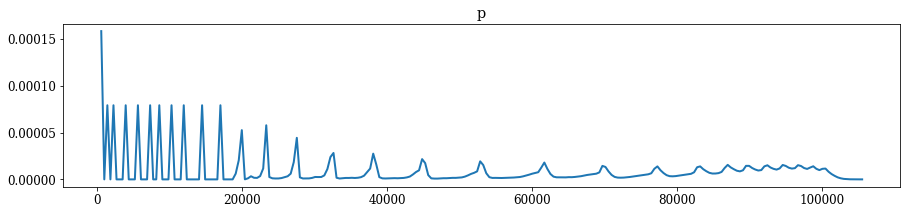

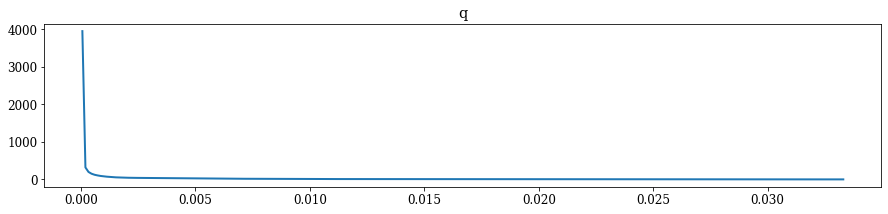

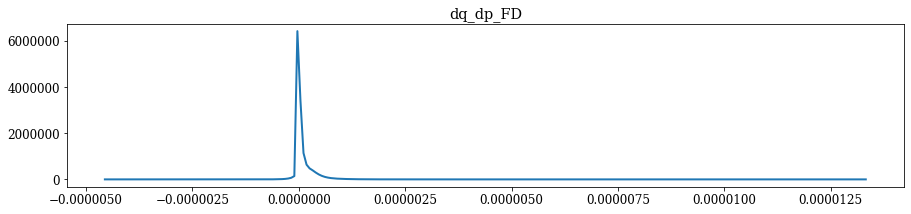

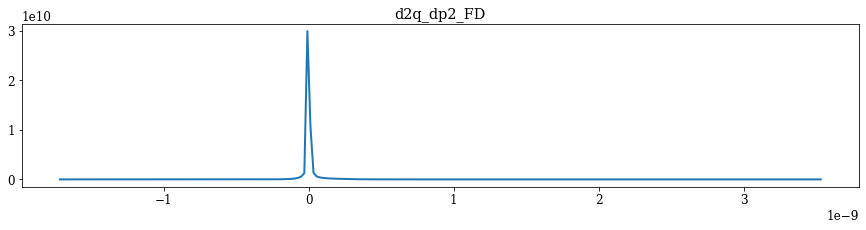

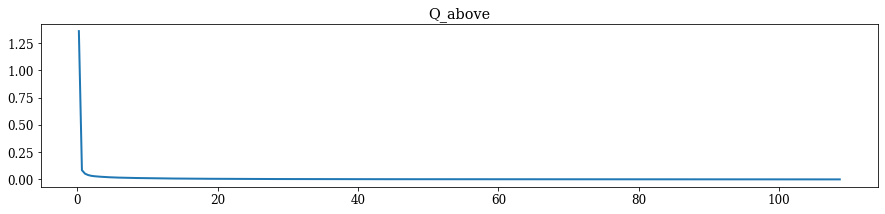

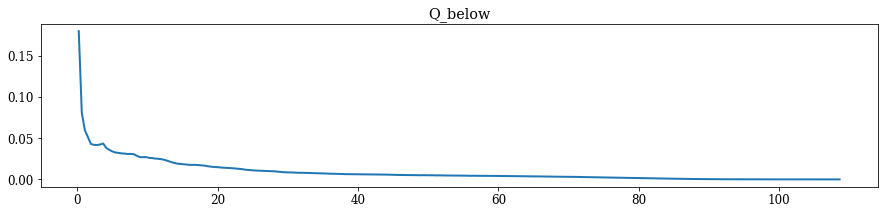

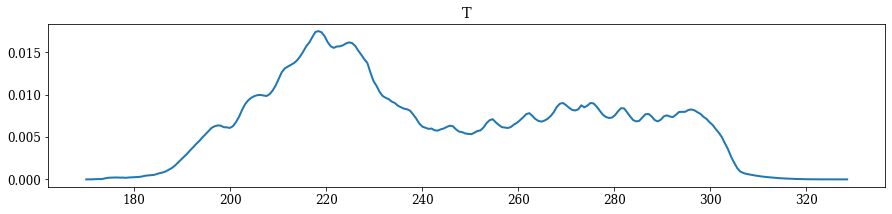

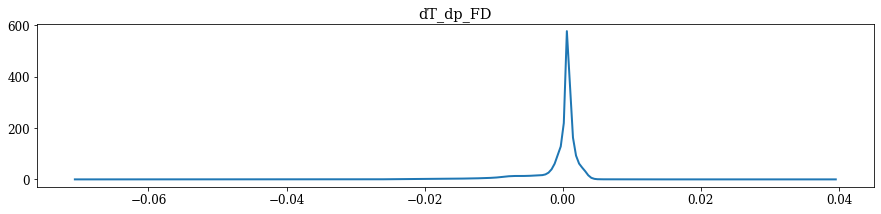

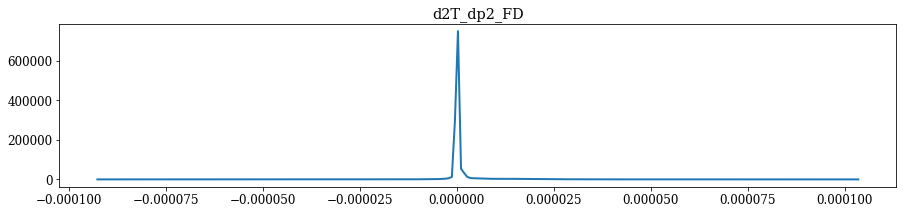

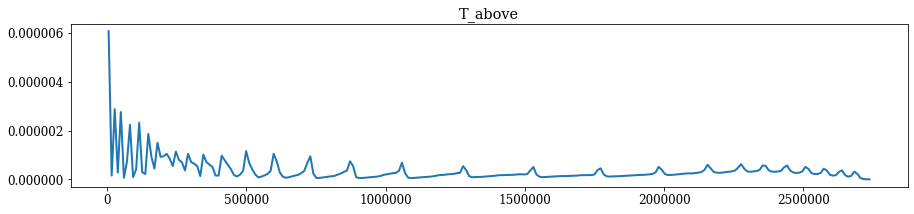

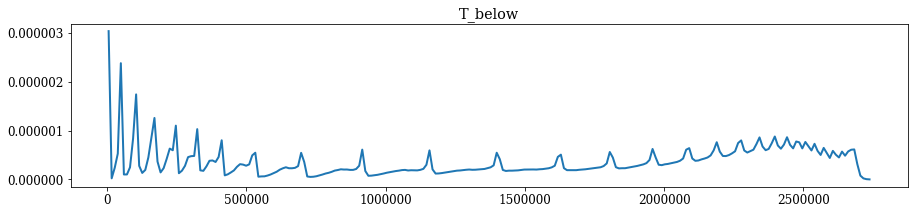

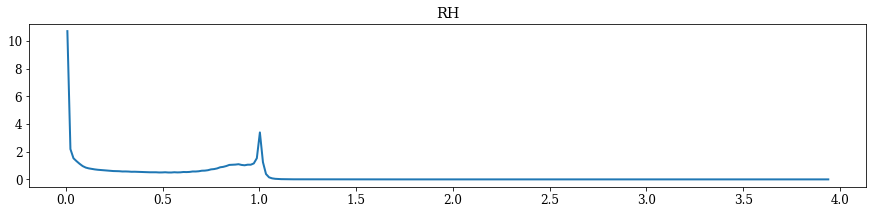

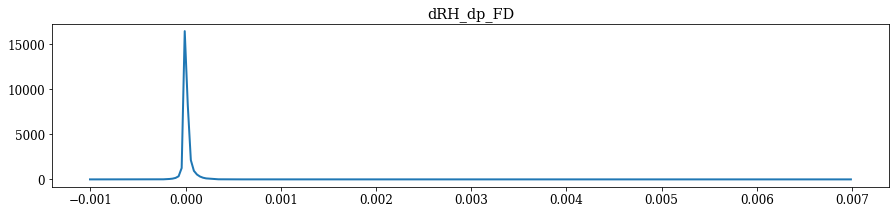

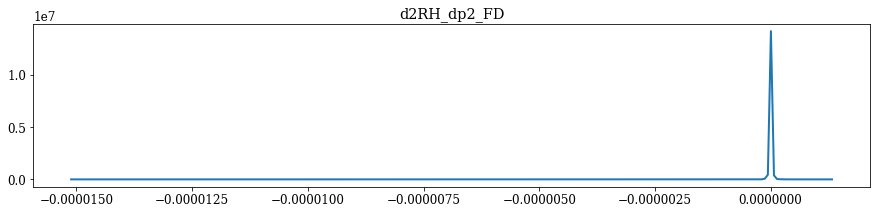

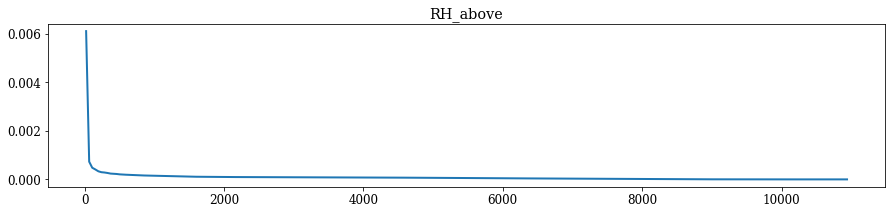

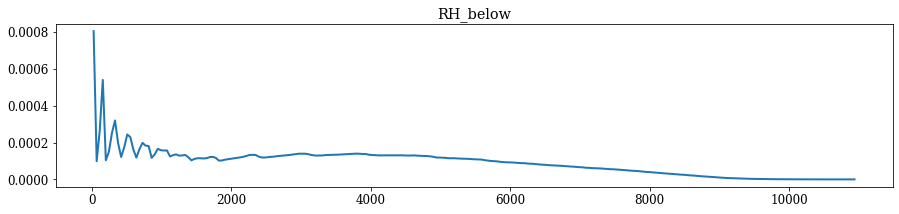

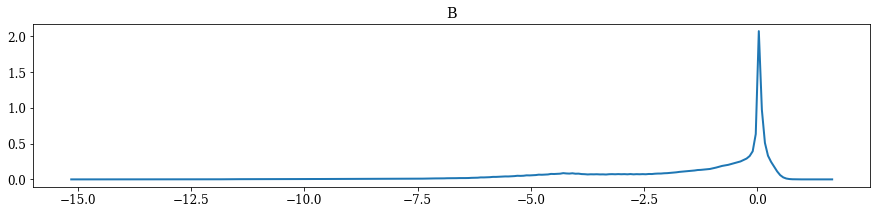

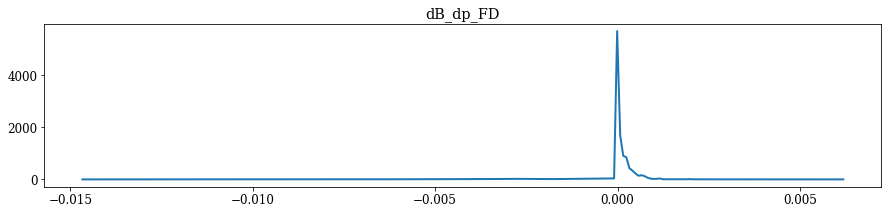

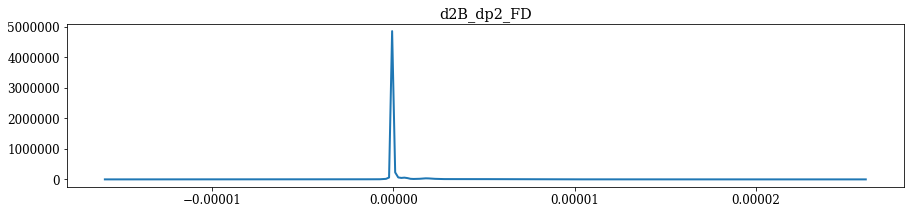

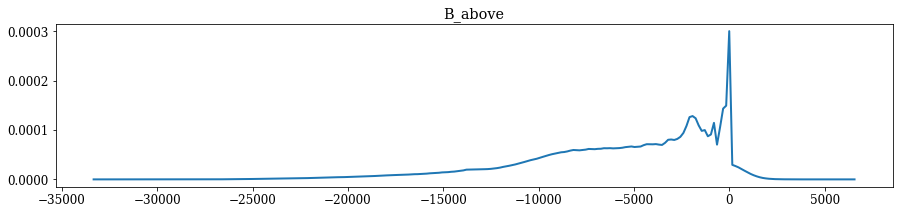

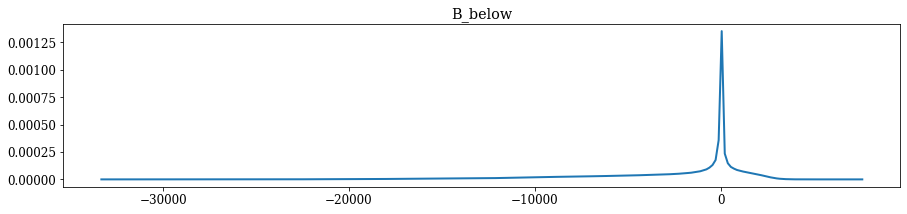

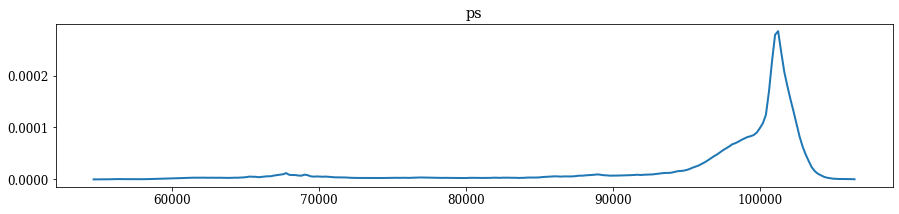

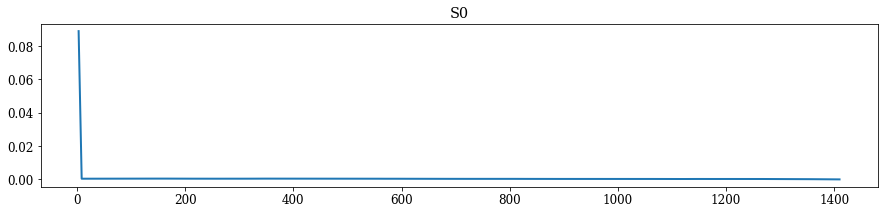

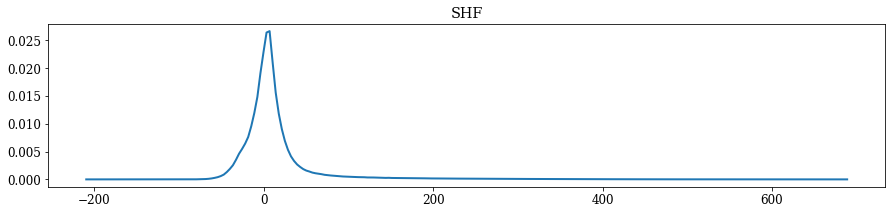

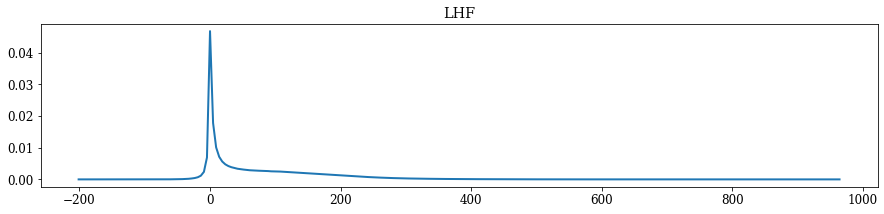

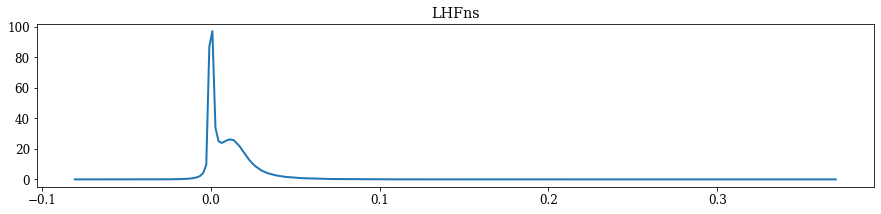

In [28]:
for k in x_train.keys():
    plt.figure(figsize=(15,3))
    plt.title(k)
    plt.plot(edg2bin(EDG[k]),PDF[k])

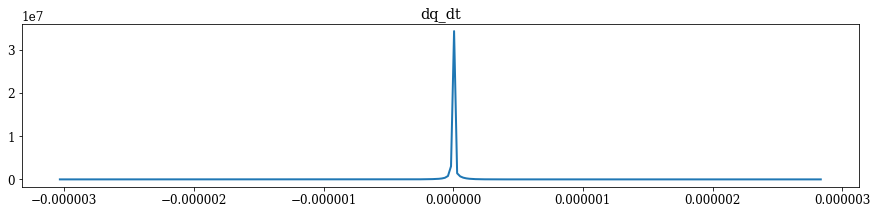

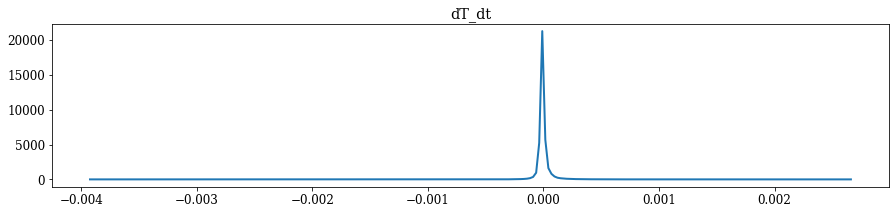

In [29]:
for k in y_train.keys():
    plt.figure(figsize=(15,3))
    plt.title(k)
    plt.plot(edg2bin(EDG[k]),PDF[k])

# Sequential Feature Selection + Polynomial/CDF fits

## Results of the analytic CDF fits

In [76]:
def CDF_keys(x0,key):
    
    from scipy.special import erfc
    from scipy.special import gamma
    from scipy.special import erf
    
    def relu(x):
        return x*(x>0)

    def log10_abs(x):
        return np.log10(np.abs(x)+1e-8)

    def cos(x):
        return np.cos(x)

    def acosh(x):
        return np.arccosh(x)
    
    def acosh_abs(x):
        return np.arccosh(np.abs(x)+1e-8+1)

    def asinh(x):
        return np.arcsinh(x)

    def cube(x):
        return x**3

    def square(x):
        return x**2

    def tanh(x):
        return np.tanh(x)

    def tan(x):
        return np.tan(x)

    def sin(x):
        return np.sin(x)

    def sinh(x):
        return np.sinh(x)

    def exp(x):
        return np.exp(x)

    def atan(x):
        return np.arctan(x)
    
    if key=='p': 
        a = 0.6412356
        b = 9.119741e-6
        cdf = a*acosh(abs(tan(b*x0)) + 1)*(x0>=0)
    elif key=='q': 
        a = 0.06532503
        b = 1.6624443125
        c = 0.016664602
        d = 0.93895346
        cdf = (a*asinh(b-c/np.maximum(1e-8,x0))+d)
    elif key=='T': 
        a = 0.0120290425
        b = 3.87931525591792
        return relu(cos(a*x0-b))*(x0<=b/a)+(x0>b/a)
    elif key=='RH': 
        a = 0.6644316
        b = 0.24918331
        cdf = tanh(x0*(x0**9+a)+b)
    elif key=='B':
        a = 0.659731659969888
        b = 0.544025486870877
        xM = 1
        cdf = (x0<xM)*erf(exp(x0/erfc(a*x0 + b))) + (x0>=xM)
    elif key=='S0': 
        a = 0.64448506
        b = 0.000751755235712102
        c = 0.497591782928156
        cdf = (a*tanh(b*x0)+c)*(x0>=0)
    elif key=='ps': 
        a = 0.128576656109525
        b = 2.55550962921948e-15
        c = 0.04589263
        cdf = a*(b*x0**3-1)**3+c
    elif key=='SHF':
        a = 0.33465865
        b = 0.076476045
        c = 0.250707280969466
        d = 0.4790062
        cdf = a*atan(b*x0-c)+d 
    elif key=='LHF': 
        a = 0.0063972594
        b = 0.05773713
        cdf = tanh(a*x0+erf(x0)-b)**3
    elif key=='LHFns':
        a = 49.3546387437862
        b = 0.25618574
        cdf = tanh(a*x0 + b)
    elif key=='dq_dt':
        a = 1.12603537628712e-9
        b = 6.266101e-10
        cdf = (x0>b)*(relu(x0)-a)/(x0-b)
    elif key=='dT_dt':
        a = 0.5001486
        b = 46935.994791982
        c = 0.5001486
        cdf = a*tanh(b*x0+1)+c
    elif key=='Q_below':
        a = 0.029036783
        b = 0.420630413085675
        c = 1.846725
        cdf = (x0>0)*tanh(x0*(a*x0+b)/(x0+c))
    elif key=='Q_above':
        a = 0.035492368
        b = 0.95200557
        c = 1.1464486
        d = 0.3115304
        e = 1.1464486
        cdf = (x0>0)*tanh(((a*x0+b)*(x0+c)-d)/(x0+e))
    elif key=='T_below':
        a = 9.9315803660139e-14
        b = 1.32339271740431e-8
        c = 0.27468704555704
        d = 133250.97
        cdf = (x0>0)*x0*(x0*(a*x0+b)+c)/(x0+d)
    elif key=='T_above':
        a = 0.9960553
        b = 2.81035e-7
        c = (1/np.log(10))
        cdf = (x0>0)*(a*abs(tan(b*x0)))**c
    elif key=='RH_below':
        a = 0.00012378559
        b = 0.061153185
        xM = 12000
        cdf = (x0>0)*erf(tan(a*x0)+b)*(x0<xM)+(x0>=xM)
    elif key=='RH_above':
        a = 0.000147361877564797
        b = 0.31168982
        c = 0.018285796
        d = 2.0008204
        cdf = (x0>0)*(erf(a*x0+b)+c-d/np.maximum(x0,1e-3))
    elif key=='B_below':
        a = 1.2917556
        b = 0.000755886110369313
        c = 1.4658872
        d = 1.97307129395484
        cdf = erf(a*atan(b*x0-c)+d)
    elif key=='B_above':
        a = 0.0453222597674014
        b = 8.23702373099799e-5
        cdf = erfc(relu(a-b*x0))
        
    return np.float32(np.maximum(0,np.minimum(1,cdf)))

## Polynomial fit without non-linear input combinations

### Parameters, keys, and normalization

In [12]:
Model_Types = ['BF','CI']
N_subsample = 5
N_degree = 4
Nsample = 3000

In [13]:
KEYS = {}
KEYS['local'] = ['ps', 'S0', 'SHF', 'LHF','LHFns','p', 'q', 'dq_dp_FD',
              'd2q_dp2_FD','T', 'dT_dp_FD','d2T_dp2_FD','RH', 'dRH_dp_FD',
              'd2RH_dp2_FD','B', 'dB_dp_FD','d2B_dp2_FD']
KEYS['localCI'] = ['ps', 'S0', 'SHF','LHFns','p','RH', 'dRH_dp_FD',
              'd2RH_dp2_FD','B', 'dB_dp_FD','d2B_dp2_FD']
KEYS['localBF'] = ['ps', 'S0', 'SHF', 'LHF', 'p', 'q', 'dq_dp_FD',
              'd2q_dp2_FD','T', 'dT_dp_FD','d2T_dp2_FD']
KEYS['all'] = np.concatenate((KEYS['local'],['Q_above','Q_below','T_below','T_above',
                                             'RH_below','RH_above','B_below','B_above']))
KEYS['BF'] = np.concatenate((KEYS['localBF'],['Q_above','Q_below','T_below','T_above']))
KEYS['CI'] = np.concatenate((KEYS['localCI'],['RH_below','RH_above','B_below','B_above']))
scalar_keys = ['ps','S0','SHF','LHF','LHFns']
vector_keys = ['p', 'q', 'dq_dp_FD', 'd2q_dp2_FD', 'Q_above', 'Q_below',
               'T', 'dT_dp_FD', 'd2T_dp2_FD', 'T_above', 'T_below',
               'RH', 'dRH_dp_FD', 'd2RH_dp2_FD', 'RH_above', 'RH_below',
               'B', 'dB_dp_FD', 'd2B_dp2_FD', 'B_above', 'B_below']
combin_keys = np.concatenate((scalar_keys,vector_keys))

In [14]:
min_features = [1,1,1,1,1]
max_features = [11,6,6,6,6]
cv = [2,2,2,2,2]

In [40]:
dict_Q = {}; dict_T = {};

In [41]:
path_data = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/SPCAM_PHYS/'
save_name = path_data+'2022_07_27_RG_NORM_PDF_CDF_TRAIN_BOTH_M4K_P4K'

tmp = pickle.load(open(save_name,'rb'))

Norm = {}
Norm['mean'] = {}
Norm['min'] = {}
Norm['max'] = {}
Norm['std'] = {}
for keys in combin_keys:
    Norm['mean'][keys] = tmp['MEAN'][keys]
    Norm['min'][keys] = tmp['MIN'][keys]
    Norm['max'][keys] = tmp['MAX'][keys]
    Norm['std'][keys] = tmp['STD'][keys] 

### Test using cold climate only

In [36]:
x = xtrain['cold']; y = ytrain['cold']; xRH = xRHtrain['cold']; xB = xBtrain['cold']; xLHFns = xLHFnstrain['cold'];

In [37]:
for i_subsample in range(N_subsample):
    print('i_subsample='+str(i_subsample)+'/'+str(N_subsample-1))
    dict_Q[i_subsample] = {}; dict_T[i_subsample] = {};
    
    # Pre-process & sub-sample the data
    i_random = np.random.choice(np.linspace(0,x.shape[0]-1,x.shape[0]),
                                size=((Nsample,)),replace=False).astype('int')
    dict_Q[i_subsample]['Selected_indices'] = i_random;
    dict_T[i_subsample]['Selected_indices'] = i_random;
    
    x_train,x_test,y_train,y_test = subsampler(i_random,x,y,xRH,xB,xLHFns,hyam,hybm,variables=KEYS['all'])
    x_train_range,x_test_range,Norm = range_normalizer(x_train,scalar_keys,vector_keys)
    
    for model_type in (Model_Types):
        print('model_type='+model_type)
        dict_Q[i_subsample][model_type] = {}; dict_T[i_subsample][model_type] = {};
        
        # Transform dictionary into array for regression purposes
        X_train,X_test,dQdt_train,dQdt_test,dTdt_train,dTdt_test = \
        dic_to_array(KEYS[model_type],x_train_range,y_train,scale_dict)
    
        for degree in np.arange(1,N_degree+1):
            print('degree='+str(degree))
            dic_to_save = {}; ideg = degree-1;
            
            # Polynomial features
            poly = PolynomialFeatures(degree=degree)
            X_train_poly = poly.fit_transform(X_train)    
            features = poly.get_feature_names(np.array(KEYS[model_type])) # Update the feature names
                
            # Linear regression on polynomial features - dQ/dt & dT/dt
            dict_Q[i_subsample][model_type][degree] = \
            SFS_poly(features,X_train_poly,dQdt_train,
                     min_features[ideg],max_features[ideg],cv[ideg])
            
            dict_T[i_subsample][model_type][degree] = \
            SFS_poly(features,X_train_poly,dTdt_train,
                     min_features[ideg],max_features[ideg],cv[ideg])
            
        # Write dict_combined to pkl file
        save_path = path_data+'Polynomial_Fits/2022_07_29_RG_M4K_dic_'+model_type+'_isample_'+str(i_subsample+1)+'.pkl'
        pickle.dump({
          "Qfits": dict_Q[i_subsample][model_type],
          "Tfits": dict_T[i_subsample][model_type],
          'Selected_indices': i_random}, open(save_path,'wb'))

i_subsample=0/4
model_type=localBF
degree=1
{'ps': -115447.19349873153, 'LR_Bias': 60893.539382385236, 'mse_train': 2575432265.406649} 

{'ps': -114011.74375026926, 'q': 29309.709214880466, 'LR_Bias': 57761.46229957759, 'mse_train': 2552149583.977285} 

{'ps': -114536.64518865109, 'q': 28114.95333732322, 'd2T_dp2_FD': 124377.88697722541, 'LR_Bias': -43954.74358399143, 'mse_train': 2537816833.149275} 

{'ps': -104012.03799518615, 'SHF': -67615.02463181638, 'q': 28146.45389557075, 'd2T_dp2_FD': 124628.98715180639, 'LR_Bias': -3758.695461577449, 'mse_train': 2529589324.838162} 

{'ps': -102785.58515218725, 'SHF': -67268.97211451297, 'q': 45000.58785001304, 'T': -18176.868038837467, 'd2T_dp2_FD': 122510.95926515442, 'LR_Bias': 4334.040450763536, 'mse_train': 2523542657.0096908} 

{'ps': -102965.42722692594, 'SHF': -67369.23993465395, 'q': 43222.85433868174, 'T': -15943.867460057532, 'dT_dp_FD': 42585.159448310085, 'd2T_dp2_FD': 174146.56725767534, 'LR_Bias': -51288.460288511764, 'mse_train

07/29/2022 04:05:49 PM Internal Python error in the inspect module.
Below is the traceback from this internal error.

07/29/2022 04:05:49 PM 
Unfortunately, your original traceback can not be constructed.



Traceback (most recent call last):
  File "/DFS-L/DATA/pritchard/tbeucler/Miniconda3_2021_04_12/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/joblib/parallel.py", line 921, in retrieve
    self._output.extend(job.get(timeout=self.timeout))
  File "/DFS-L/DATA/pritchard/tbeucler/Miniconda3_2021_04_12/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/joblib/_parallel_backends.py", line 542, in wrap_future_result
    return future.result(timeout=timeout)
  File "/DFS-L/DATA/pritchard/tbeucler/Miniconda3_2021_04_12/miniconda3/envs/CbrainCustomLayer/lib/python3.6/concurrent/futures/_base.py", line 427, in result
    self._condition.wait(timeout)
  File "/DFS-L/DATA/pritchard/tbeucler/Miniconda3_2021_04_12/miniconda3/envs/CbrainCustomLayer/lib/python3.6/threading.py", line 295, in wait
    waiter.acquire()
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/DFS-L/DATA/pritchard/tbeucle

TypeError: object of type 'NoneType' has no len()

### Loop over samples

In [ ]:
for i_subsample in range(N_subsample):
    print('i_subsample='+str(i_subsample)+'/'+str(N_subsample-1))
    dict_Q[i_subsample] = {}; dict_T[i_subsample] = {};
    
    x_train = {}; y_train = {};
    for Tkey in ['cold','hot']:
        print(Tkey)
    # Pre-process & sub-sample the data
        print('Selecting random indices without replacement','                                   ',end='\r')
        i_random = np.random.choice(np.linspace(0,xtrain[Tkey].shape[0]-1,xtrain[Tkey].shape[0]),
                                    size=((Nsample,)),replace=False).astype('int')
        dict_Q[i_subsample]['Selected_indices_'+Tkey] = i_random;
        dict_T[i_subsample]['Selected_indices_'+Tkey] = i_random;
        print('Subsampling','                                   ',end='\r')
        x_train[Tkey],x_test,y_train[Tkey],y_test = subsampler(i_random,xtrain[Tkey],ytrain[Tkey],
                                                               xRHtrain[Tkey],xBtrain[Tkey],xLHFnstrain[Tkey],
                                                               hyam,hybm,variables=KEYS['all'])
    
    print('Concatenating','                                   ',end='\r')
    x_train['both'] = {}; y_train['both'] = {};
    for k in x_train['cold'].keys():
        x_train['both'][k] = np.concatenate((x_train['cold'][k],x_train['hot'][k]),axis=0)
    for k in y_train['cold'].keys():
        y_train['both'][k] = np.concatenate((y_train['cold'][k],y_train['hot'][k]),axis=0)
    
    print('Normalizing','                                   ')
    x_train_range,x_test_range,Norm = range_normalizer(x_train['both'],scalar_keys,vector_keys,Norm = Norm)
    
    for model_type in (Model_Types):
        print('model_type='+model_type)
        dict_Q[i_subsample][model_type] = {}; dict_T[i_subsample][model_type] = {};
        
        # Transform dictionary into array for regression purposes
        X_train,X_test,dQdt_train,dQdt_test,dTdt_train,dTdt_test = \
        dic_to_array(KEYS[model_type],x_train_range,y_train['both'],scale_dict)
    
        for degree in np.arange(1,N_degree+1):
            print('degree='+str(degree))
            dic_to_save = {}; ideg = degree-1;
            
            # Polynomial features
            poly = PolynomialFeatures(degree=degree)
            X_train_poly = poly.fit_transform(X_train)    
            features = poly.get_feature_names(np.array(KEYS[model_type])) # Update the feature names
                
            # Linear regression on polynomial features - dQ/dt & dT/dt
            dict_Q[i_subsample][model_type][degree] = \
            SFS_poly(features,X_train_poly,dQdt_train,
                     min_features[ideg],max_features[ideg],cv[ideg])
            
            dict_T[i_subsample][model_type][degree] = \
            SFS_poly(features,X_train_poly,dTdt_train,
                     min_features[ideg],max_features[ideg],cv[ideg])
            
        # Write dict_combined to pkl file
        save_path = path_data+'Polynomial_Fits/2022_07_27_RG_'+model_type+'_isample_'+str(i_subsample+1)+'.pkl'
        pickle.dump({
          "Qfits": dict_Q[i_subsample][model_type],
          "Tfits": dict_T[i_subsample][model_type],
          'Selected_indices': i_random}, open(save_path,'wb'))

i_subsample=0/4
cold
hotsampling                                                                     
Normalizing                                                                     
model_type=all
degree=1
{'RH_above': -24.136242574359045, 'LR_Bias': 10.757106296207985, 'mse_train': 920.1362984577497} 

{'dq_dp_FD': 299.02442310499896, 'RH_above': -27.13988054530147, 'LR_Bias': -59.610353193419805, 'mse_train': 912.8369359533406} 

{'dq_dp_FD': 300.69713357285065, 'Q_below': -13.27325575367543, 'RH_above': -31.638424470730698, 'LR_Bias': -56.08918466360696, 'mse_train': 908.6199352276818} 

{'dq_dp_FD': 279.6226300631897, 'Q_below': -10.727717932861337, 'RH_below': -10.735710768120734, 'RH_above': -32.05783357718331, 'LR_Bias': -45.25313071546945, 'mse_train': 906.1215542328323} 

{'dq_dp_FD': 376.21488539735435, 'T': -9.037467725671664, 'Q_below': -11.164544846031571, 'RH_below': -13.00308496827291, 'RH_above': -27.053772869459177, 'LR_Bias': -65.40263943722667, 'mse_train': 904.5330

{'LHFns q RH_below B_below': -2626.9669369207363, 'LR_Bias': 1.5530943401743926, 'mse_train': 900.6942316779292} 

{'LHF q T B_below': 7100.913596469333, 'LHFns q RH_below B_below': -11993.774833738142, 'LR_Bias': 1.1472340939107617, 'mse_train': 845.6299065389557} 

{'dq_dp_FD': 385.07617336105494, 'LHF q T B_below': 6395.019479777905, 'LHFns q RH_below B_below': -11781.744660109303, 'LR_Bias': -90.67716355545377, 'mse_train': 835.7849521063189} 

{'dq_dp_FD': 394.23046464617, 'LHF q T B_below': 6155.4985659654585, 'LHFns q RH_below B_below': -11198.514390936947, 'LHFns RH_below RH_above^2': -157.71529907648213, 'LR_Bias': -89.25067923459162, 'mse_train': 832.8523923670339} 

{'dq_dp_FD': 414.20959338095145, 'LHF q T B_below': 6670.029097987878, 'LHFns q RH_below B_below': -13554.685318372236, 'LHFns RH_below RH_above^2': -125.32728522003289, 'q Q_below T_below RH_below': 922.9786915974231, 'LR_Bias': -94.40883231041046, 'mse_train': 830.8427005797575} 

{'SHF LHFns RH_below RH_above'

## CDF and polynomial fits together

In [83]:
Model_Types = ['CDF_only','BF_CDF','CI_CDF','BF','CI']
N_subsample = 5
N_degree = 3
Nsample = 5000

KEYS = {}
KEYS['local'] = ['ps', 'S0', 'SHF', 'LHF','LHFns','p', 'q', 'dq_dp_FD',
              'd2q_dp2_FD','T', 'dT_dp_FD','d2T_dp2_FD','RH', 'dRH_dp_FD',
              'd2RH_dp2_FD','B', 'dB_dp_FD','d2B_dp2_FD']
KEYS['localCI'] = ['ps', 'S0', 'SHF','LHFns','p','RH', 'dRH_dp_FD',
              'd2RH_dp2_FD','B', 'dB_dp_FD','d2B_dp2_FD']
KEYS['localBF'] = ['ps', 'S0', 'SHF', 'LHF', 'p', 'q', 'dq_dp_FD',
              'd2q_dp2_FD','T', 'dT_dp_FD','d2T_dp2_FD']
KEYS['all'] = np.concatenate((KEYS['local'],['Q_above','Q_below','T_below','T_above',
                                             'RH_below','RH_above','B_below','B_above']))
KEYS['BF'] = np.concatenate((KEYS['localBF'],['Q_above','Q_below','T_below','T_above']))
KEYS['CI'] = np.concatenate((KEYS['localCI'],['RH_below','RH_above','B_below','B_above']))
scalar_keys = ['ps','S0','SHF','LHF','LHFns']
vector_keys = ['p', 'q', 'dq_dp_FD', 'd2q_dp2_FD', 'Q_above', 'Q_below',
               'T', 'dT_dp_FD', 'd2T_dp2_FD', 'T_above', 'T_below',
               'RH', 'dRH_dp_FD', 'd2RH_dp2_FD', 'RH_above', 'RH_below',
               'B', 'dB_dp_FD', 'd2B_dp2_FD', 'B_above', 'B_below']
combin_keys = np.concatenate((scalar_keys,vector_keys))
KEYS['CDF_vector'] = ['p','q','T','RH','B']
KEYS['CDF_vector2'] = ['Q_above', 'Q_below',
                       'T_above','T_below',
                       'RH_above','RH_below',
                       'B_above','B_below']
KEYS['CDF_scalar'] = ['S0','ps','SHF','LHF','LHFns']
KEYS['CDF'] = np.concatenate((KEYS['CDF_vector'],KEYS['CDF_vector2'],KEYS['CDF_scalar']))
for k in KEYS['CDF_scalar']:
    scalar_keys = np.concatenate((scalar_keys,['CDF_'+k]))
for k in KEYS['CDF_vector']:
    vector_keys = np.concatenate((vector_keys,['CDF_'+k,'dCDF_'+k+'dp_FD','d2CDF_'+k+'dp2_FD']))
for k in KEYS['CDF_vector2']:
    vector_keys = np.concatenate((vector_keys,['CDF_'+k]))
combin_keys = np.concatenate((scalar_keys,vector_keys))
KEYS['BF_CDF_only'] = ['CDF_S0', 'CDF_ps', 'CDF_SHF', 'CDF_LHF','CDF_p','CDF_q', 'dCDF_qdp_FD',
                       'd2CDF_qdp2_FD', 'CDF_T', 'dCDF_Tdp_FD','d2CDF_Tdp2_FD',
                       'CDF_Q_above', 'CDF_Q_below', 'CDF_T_above','CDF_T_below']
KEYS['BF_CDF'] = np.concatenate((KEYS['BF'],KEYS['BF_CDF_only']))
KEYS['CI_CDF_only'] = ['CDF_S0', 'CDF_ps', 'CDF_SHF', 'CDF_LHFns',
                  'CDF_p','CDF_RH','dCDF_RHdp_FD', 'd2CDF_RHdp2_FD',
                  'CDF_B', 'dCDF_Bdp_FD','d2CDF_Bdp2_FD',
                  'CDF_RH_above', 'CDF_RH_below', 'CDF_B_above','CDF_B_below']
KEYS['CI_CDF'] = np.concatenate((KEYS['CI'],KEYS['CI_CDF_only']))

KEYS['CDF_only'] = np.concatenate((KEYS['BF_CDF_only'],KEYS['CI_CDF_only']))[5:]

min_features = [1,1,1,1,1]
max_features = [11,6,6,6,6]
cv = [2,2,2,2,2]

dict_Q = {}; dict_T = {};

In [ ]:
## Second attempt, this time using both the cold and the warm parts of the dataset

for i_subsample in range(N_subsample):
    print('i_subsample='+str(i_subsample)+'/'+str(N_subsample-1))
    dict_Q[i_subsample] = {}; dict_T[i_subsample] = {};
    
    x_train = {}; y_train = {};
    for Tkey in ['cold','hot']:
        print('Climate is ',Tkey)
    # Pre-process & sub-sample the data
        print('Selecting random indices without replacement','                                   ',end='\r')
        i_random = np.random.choice(np.linspace(0,xtrain[Tkey].shape[0]-1,xtrain[Tkey].shape[0]),
                                    size=((Nsample,)),replace=False).astype('int')
        dict_Q[i_subsample]['Selected_indices_'+Tkey] = i_random;
        dict_T[i_subsample]['Selected_indices_'+Tkey] = i_random;
        print('Subsampling','                                   ',end='\r')
        x_train[Tkey],x_test,y_train[Tkey],y_test = subsampler(i_random,xtrain[Tkey],ytrain[Tkey],
                                                               xRHtrain[Tkey],xBtrain[Tkey],xLHFnstrain[Tkey],
                                                               hyam,hybm,variables=KEYS['all'])
    
    print('Concatenating','                                   ',end='\r')
    x_train['both'] = {}; y_train['both'] = {};
    for k in x_train['cold'].keys():
        x_train['both'][k] = np.concatenate((x_train['cold'][k],x_train['hot'][k]),axis=0)
    for k in y_train['cold'].keys():
        y_train['both'][k] = np.concatenate((y_train['cold'][k],y_train['hot'][k]),axis=0)
    
    print('Calculating CDF','                                 ',end='\r')
    for k in KEYS['CDF']:
        print('key=',k,'                                 ',end='\r')
        x_train['both']['CDF_'+k] = CDF_keys(x_train['both'][k],k)
        if k in KEYS['CDF_vector']:
            x_train['both']['dCDF_'+k+'dp_FD'] = p_derivative(x_train['both']['CDF_'+k],x_train['both']['p'])
            x_train['both']['d2CDF_'+k+'dp2_FD'] = p_derivative(x_train['both']['dCDF_'+k+'dp_FD'],x_train['both']['p'])
    
    print('Normalizing                                        ',end='\r')
    x_train_range,x_test_range,Norm = range_normalizer(x_train['both'],scalar_keys,vector_keys)
    
    for model_type in (Model_Types):
        print('model_type='+model_type)
        dict_Q[i_subsample][model_type] = {}; dict_T[i_subsample][model_type] = {};
        
        # Transform dictionary into array for regression purposes
        X_train,X_test,dQdt_train,dQdt_test,dTdt_train,dTdt_test = \
        dic_to_array(KEYS[model_type],x_train_range,y_train['both'],scale_dict)
    
        for degree in np.arange(1,N_degree+1):
            print('degree='+str(degree))
            dic_to_save = {}; ideg = degree-1;
            
            # Polynomial features
            poly = PolynomialFeatures(degree=degree)
            X_train_poly = poly.fit_transform(X_train)    
            features = poly.get_feature_names(np.array(KEYS[model_type])) # Update the feature names
                
            # Linear regression on polynomial features - dQ/dt & dT/dt
            dict_Q[i_subsample][model_type][degree] = \
            SFS_poly(features,X_train_poly,dQdt_train,
                     min_features[ideg],max_features[ideg],cv[ideg])
            
            dict_T[i_subsample][model_type][degree] = \
            SFS_poly(features,X_train_poly,dTdt_train,
                     min_features[ideg],max_features[ideg],cv[ideg])
            
        # Write dict_combined to pkl file
        save_path = path_data+'Polynomial_Fits/2022_08_05_dicRG_'+model_type+'_isubsample_'+str(i_subsample+1)+\
        '_Nsample_'+str(Nsample)+'.pkl'
        pickle.dump({
          "Qfits": dict_Q[i_subsample][model_type],
          "Tfits": dict_T[i_subsample][model_type],
          'Selected_indices': i_random}, open(save_path,'wb'))


i_subsample=0/4
Climate is  cold


# Appendix A: Convert q,T,LHF to RH,B,LHFns to form the climate-invariant variables

## Data Generators

In [13]:
N_batch = 8192

In [14]:
def train_gen_rescaling(input_rescaling,path_norm,path_train,scale_dict):
    return DataGeneratorCI(
        data_fn = path_train,
        input_vars = input_rescaling,
        output_vars = out_vars,
        norm_fn = path_norm,
        input_transform = ('mean', 'maxrs'),
        output_transform = scale_dict)

In [15]:
# Here we are just rescaling by the same constants because we don't
in_vars = ['QBP','TBP','PS','SOLIN','SHFLX','LHFLX']
out_vars = ['PHQ','TPHYSTND']
train_gen_RH = train_gen_rescaling(in_vars,path_input_norm,path_array['cold'][0],scale_dict)
train_gen_BMSE = train_gen_rescaling(in_vars,path_input_norm,path_array['cold'][0],scale_dict)
train_gen_LHF_nsDELQ = train_gen_rescaling(in_vars,path_input_norm,path_array['cold'][0],scale_dict)

In [16]:
# train_gen_RH = train_gen_rescaling(['RH','TBP','PS', 'SOLIN', 'SHFLX', 'LHFLX'],
#                                    path_norm_RH,path_train_RH,scale_dict_RH)
# train_gen_BMSE = train_gen_rescaling(['QBP','BMSE','PS', 'SOLIN', 'SHFLX', 'LHFLX'],
#                                      path_norm_BMSE,path_train_BMSE,scale_dict)
# train_gen_LHF_nsDELQ = train_gen_rescaling(['QBP','TBP','PS', 'SOLIN', 'SHFLX', 'LHF_nsDELQ'],
#                                            path_norm_LHF_nsDELQ,path_train_LHF_nsDELQ,scale_dict)

In [17]:
def Generator_singleDS(path,rescaling=None):
    
    in_vars = ['QBP','TBP','PS','SOLIN','SHFLX','LHFLX'] # We take the large-scale climate state as inputs
    out_vars = ['PHQ','TPHYSTND','QRL','QRS'] # and we output the response of clouds/storms to these climate conditions
    path_input_norm = path_data + '2021_04_18_NORM_RG_small.nc'
    scale_dict = pickle.load(open(path_data+'009_Wm2_scaling.pkl','rb'))
    
    if rescaling=='CI':
        gen = DataGeneratorCI(
        data_fn = path,
        input_vars = in_vars,
        output_vars = out_vars,
        norm_fn = path_input_norm,
        batch_size=N_batch,
        input_transform = ('mean', 'maxrs'),
        output_transform = scale_dict,
        Qscaling = 'RH',
        Tscaling = 'BMSE',
        LHFscaling = 'LHF_nsDELQ',
        hyam=hyam, hybm=hybm, # Arrays to define mid-levels of hybrid vertical coordinate
        inp_sub_Qscaling=train_gen_RH.input_transform.sub, # What to subtract from RH inputs
        inp_div_Qscaling=train_gen_RH.input_transform.div, # What to divide RH inputs by
        inp_sub_Tscaling=train_gen_BMSE.input_transform.sub,
        inp_div_Tscaling=train_gen_BMSE.input_transform.div,
        inp_sub_LHFscaling=train_gen_LHF_nsDELQ.input_transform.sub,
        inp_div_LHFscaling=train_gen_LHF_nsDELQ.input_transform.div
        ) 
    else:
        gen = DataGeneratorCI(
        data_fn = path,
        input_vars = in_vars,
        output_vars = out_vars,
        norm_fn = path_input_norm,
        batch_size=N_batch,
        input_transform = ('mean', 'maxrs'),
        output_transform = scale_dict
        )

    return gen 

In [18]:
BFgen = {}
CIgen = {}

In [19]:
for iclimate,clim in enumerate(climates):
    print('Climate = ',clim)
    BFgen[clim] = {}
    CIgen[clim] = {}
    
    for iset,st in enumerate(set_str):
        print('Set = ',st)
        
        BFgen[clim][st] = Generator_singleDS(path_array[clim][iset])
        CIgen[clim][st] = Generator_singleDS(path_array[clim][iset],rescaling='CI')

Climate =  cold
Set =  train
Set =  valid
Set =  test
Climate =  medium
Set =  train
Set =  valid
Set =  test
Climate =  hot
Set =  train
Set =  valid
Set =  test


## Create array to hold rescaled variables

In [20]:
clim = 'cold'; set0 = 'test'; iset = 2;

In [21]:
gen = CIgen[clim][set0]
train_set = xr.open_dataset(path_array[clim][iset])
train_CI = train_set.copy()
var_names_CI = train_CI['var_names'].values

In [22]:
for i in range(60):
    if i<30: var_names_CI[i] = 'RH'
    else: var_names_CI[i] = 'BMSE'
var_names_CI[63] = 'LHF_nsDELQ'

In [23]:
train_CI.assign_coords({'var_names':var_names_CI});

In [24]:
newval_train = np.zeros(train_CI['vars'].shape,dtype='float16')

## Assign new values using climate-invariant generators

In [25]:
for ibatch in range((gen.n_samples)//N_batch):
    if ibatch % 10==0: print('progress=','%2.2f' % \
                             (100*ibatch/((gen.n_samples)//N_batch)),
                             '%','               ',end='\r')
    gen_pu = np.float32((gen[ibatch][0]*gen.input_transform.div+gen.input_transform.sub))
    newval_train[ibatch*N_batch:((1+ibatch)*N_batch),:] = np.concatenate(
        (gen_pu[:,:64],np.float32(train_CI['vars'][ibatch*N_batch:((1+ibatch)*N_batch),64:])),axis=1)

08/05/2022 02:31:55 AM findfont: Matching :family=serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
08/05/2022 02:31:55 AM findfont: score(<Font 'STIXGeneral' (STIXGeneralBolIta.ttf) italic normal bold normal>) = 11.335
08/05/2022 02:31:55 AM findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymBol.ttf) normal normal bold normal>) = 10.335
08/05/2022 02:31:55 AM findfont: score(<Font 'cmsy10' (cmsy10.ttf) normal normal 400 normal>) = 10.05
08/05/2022 02:31:55 AM findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05
08/05/2022 02:31:55 AM findfont: score(<Font 'DejaVu Serif Display' (DejaVuSerifDisplay.ttf) normal normal 400 normal>) = 10.05
08/05/2022 02:31:55 AM findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Bold.ttf) normal normal bold normal>) = 10.335
08/05/2022 02:31:55 AM findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBol.ttf) normal normal bold normal>) = 10.335
08/05/2022 02:31:55 AM findfont: score(<Font 'STIXGe

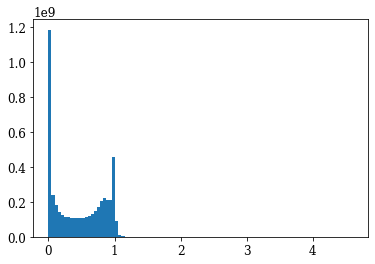

In [26]:
plt.hist(newval_train[:,:30].flatten(),bins=100);

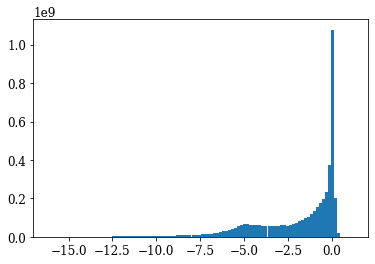

In [27]:
plt.hist(newval_train[:,30:60].flatten(),bins=100);

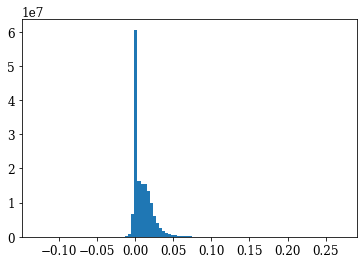

In [28]:
plt.hist(newval_train[:,63].flatten(),bins=100);

## Extract and save RH, B, and LHF_nsDELQ

In [29]:
RH_train = np.float32(newval_train[:,:30])
B_train = np.float32(newval_train[:,30:60])
LHFnsDELQ_train = np.float32(newval_train[:,63])

In [30]:
data = dict(
        RH_train=(["samples_both","pressure"],RH_train),
        B_train=(["samples_both","pressure"],B_train),
        LHFnsDELQ_train=(["samples_both"],LHFnsDELQ_train))

In [31]:
PS = newval_train[:100000,60]
pi = P0*hyai+np.outer(PS,hybi)
pm = P0*hyam+np.outer(PS,hybm)

/DFS-L/DATA/pritchard/tbeucler/Miniconda3_2021_04_12/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/numpy/core/numeric.py:906: RuntimeWarning: invalid value encountered in multiply
  return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis, :], out)


In [32]:
coord = dict(
        pressure_midlevel=(["pressure"],np.mean(pm,axis=0)),
        pressure_interfac=(["pressure_interface"],np.mean(pi,axis=0)),
        samples_mixed=(["samples_both"],np.arange(0,RH_train.shape[0]))
    )

In [33]:
da = xr.Dataset(
    data_vars=data,
    coords=coord,
    attrs=dict(description="RH, B, and LHF_nsDELQ calculated using script [098]")
)

In [34]:
da.to_netcdf(path_data+'2022_07_21_RG_B_RH_LHFns_TEST_m4K.nc')